In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
sns.set(font_scale = 1.5)

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
buoy_data = pd.read_csv('../data-sources/forecasting-floats/cleaned-buoy-data.csv')

In [4]:
def plot_autocorrs(data, buoy_id, feature, lags, alpha=0.05):
    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(data[data['Spot Id'] == buoy_id][feature][1:-2]))
    fig, ax = plt.subplots(nrows=2, figsize=(15, 8), sharey=True)
    plot_acf(data[data['Spot Id'] == buoy_id][feature][1:-2], lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title(f'{feature} Autocorrelation')
    plot_pacf(data[data['Spot Id'] == buoy_id][feature][1:-2], lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title(f'{feature} Partial Autocorrelation')
    plt.show()

In [5]:
def plot_diff(data, buoy_id, feature):
    fig, ax = plt.subplots(nrows=3, figsize=(15, 12))
    data[data['Spot Id'] == buoy_id][feature].plot(kind='line', color=['crimson'], lw=2, ax=ax[0])
    ax[0].set_title(f'{feature}')
    data[data['Spot Id'] == buoy_id][feature].diff()[1:].plot(kind='line', color=['crimson'], lw=2, ax=ax[1])
    ax[1].set_title(f'{feature} Differenced Once')
    data[data['Spot Id'] == buoy_id][feature].diff().diff()[2:].plot(kind='line', color=['crimson'], lw=2, ax=ax[2])
    ax[2].set_title(f'{feature} Differenced Twice')
    plt.show()

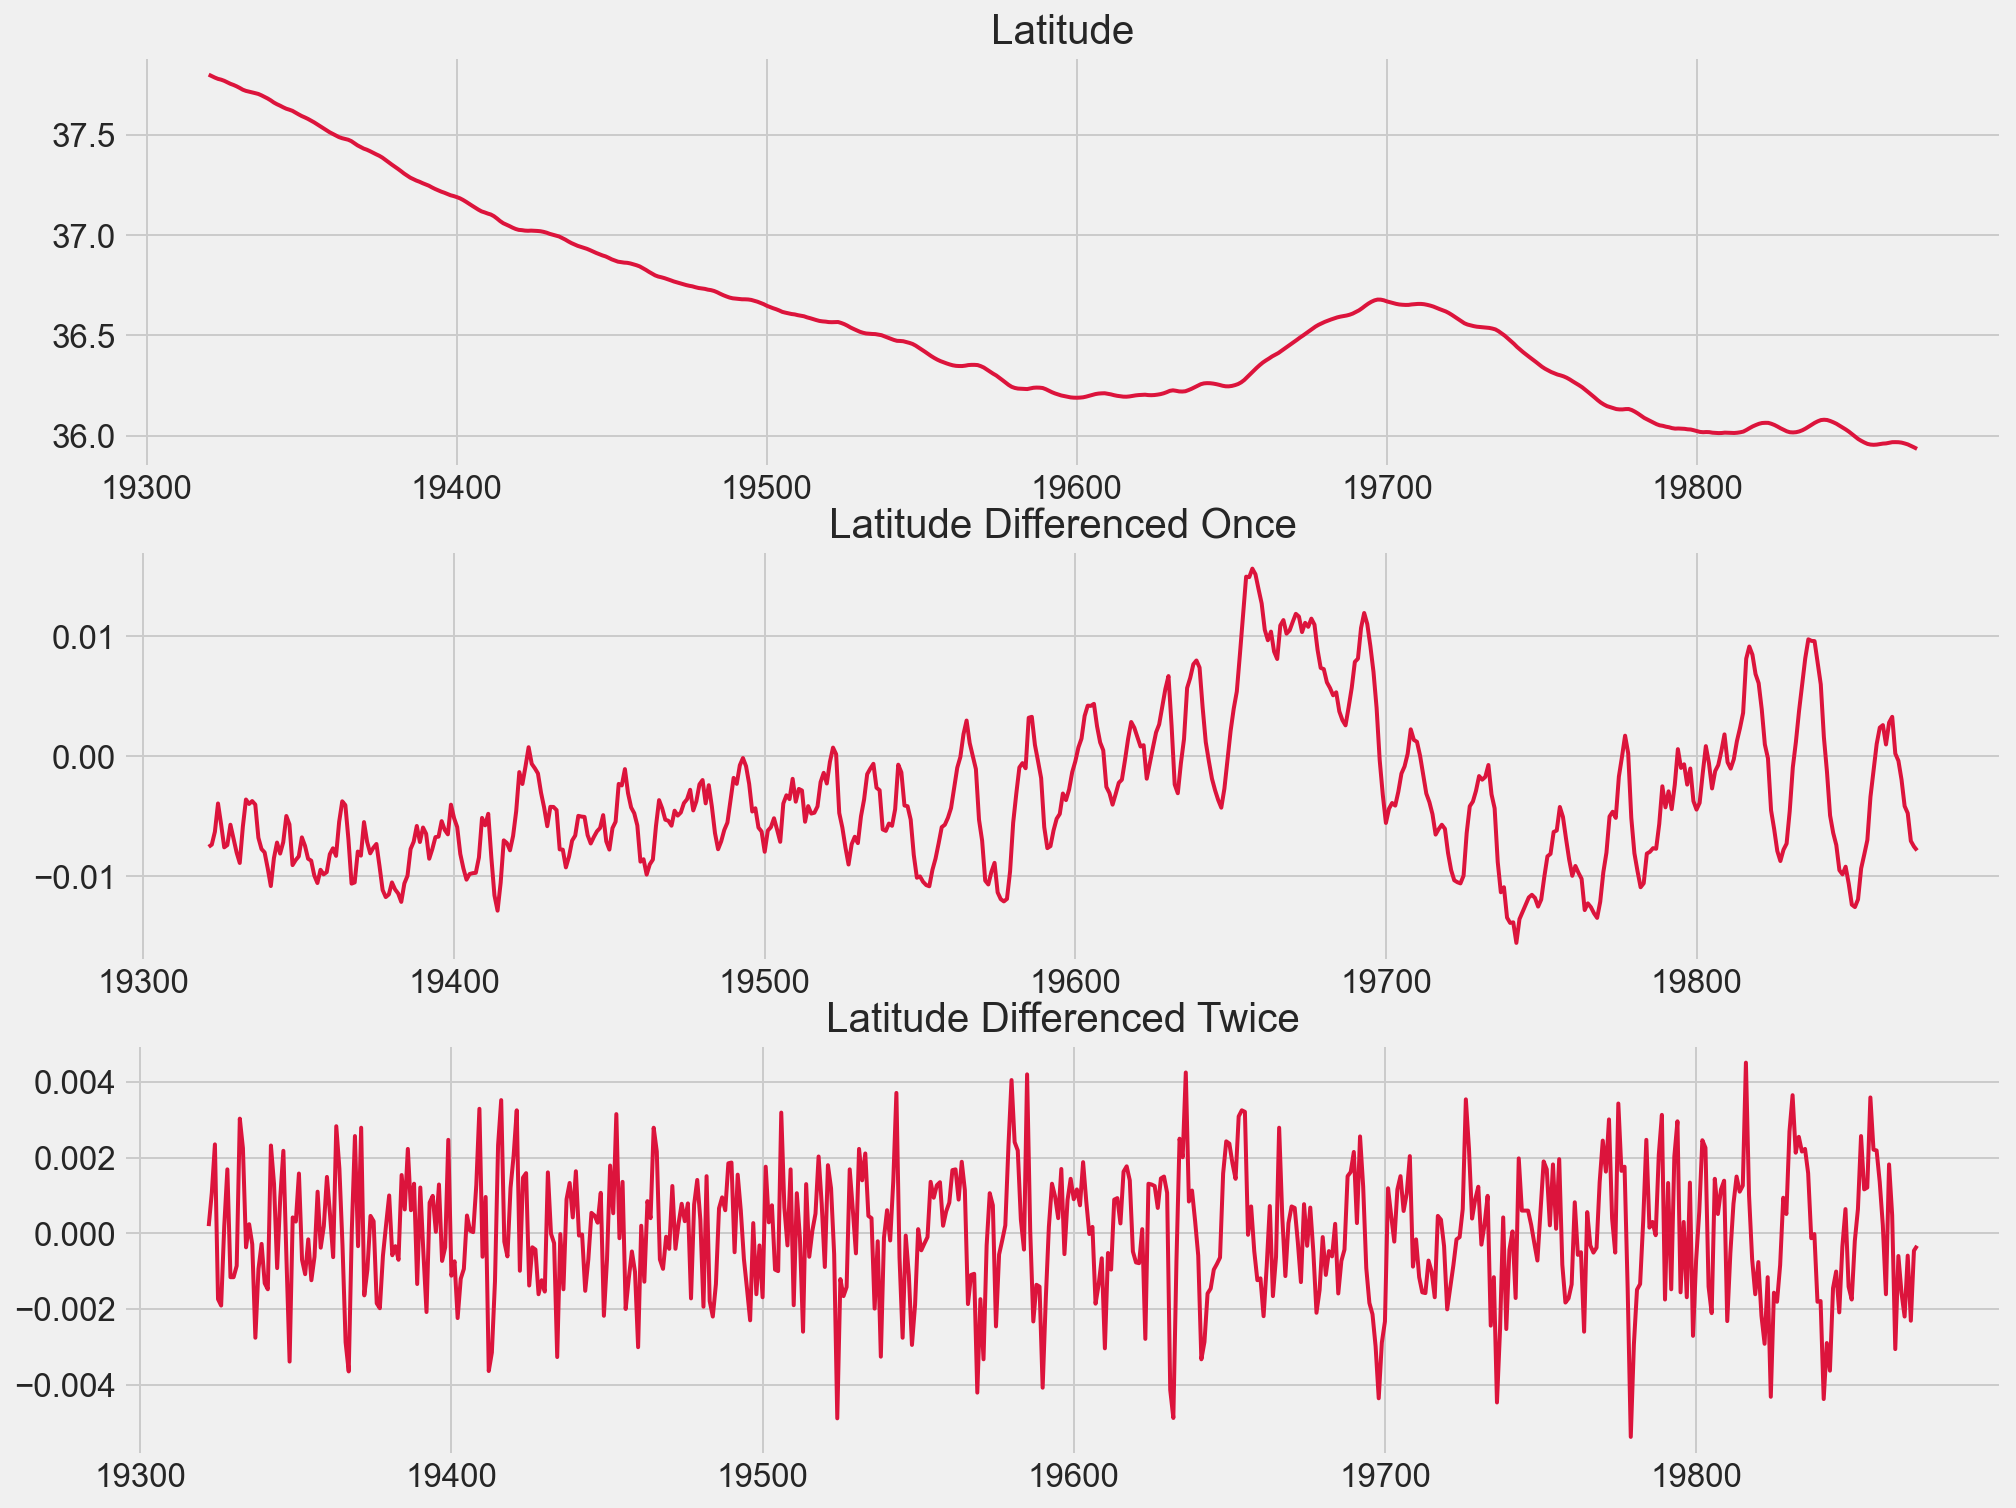

In [6]:
plot_diff(buoy_data, 35, 'Latitude')

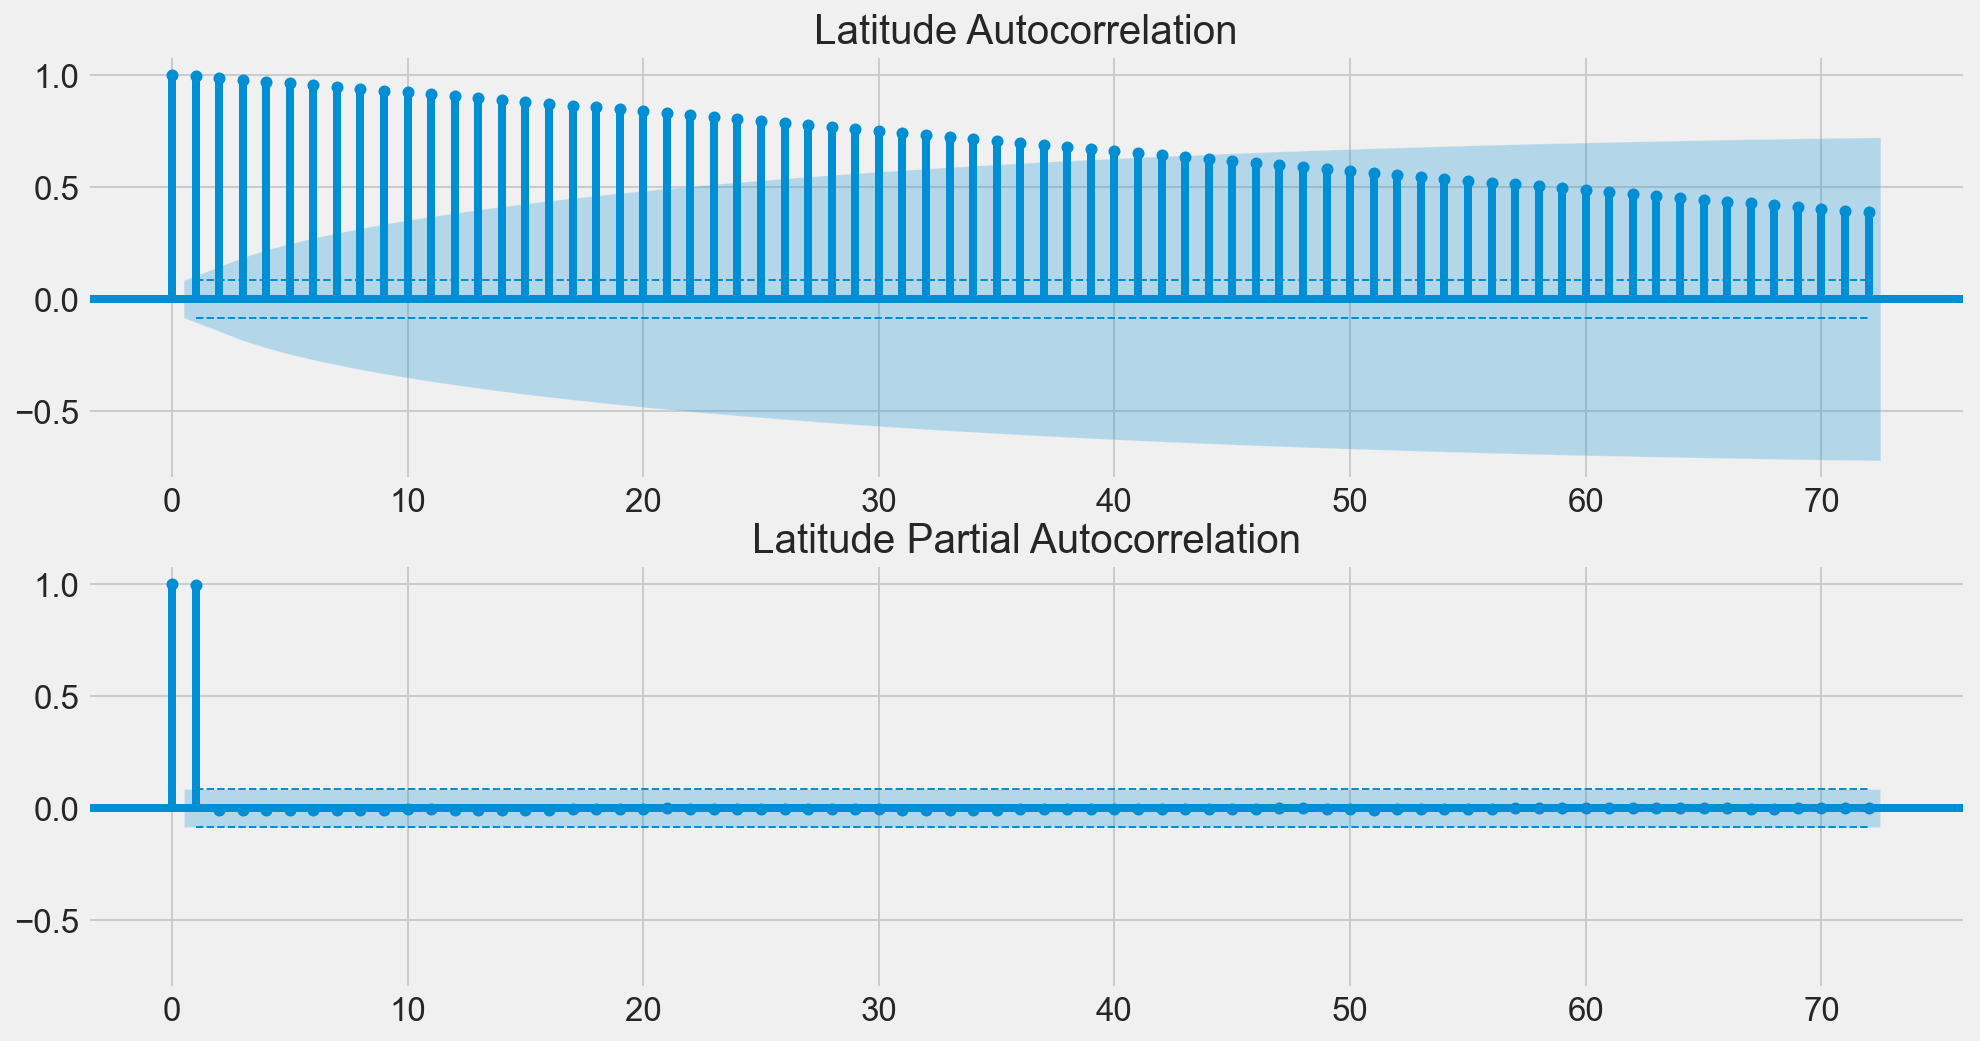

In [7]:
plot_autocorrs(buoy_data, 35, 'Latitude', 72)

In [8]:
def make_predict(data, buoy_id, feature, order, start_p, end_p):
    series = data[data['Spot Id'] == buoy_id][feature].reset_index(drop=True)
    model = sm.tsa.statespace.SARIMAX(series, order=order, trend='c')
    results = model.fit(maxiter=5000)
    print(results.summary())
    
    preds = results.predict(start=0, end=len(series)+end_p, dynamic=False)
    preds_dyn = results.predict(start=len(series)-start_p, end=len(series)+end_p, dynamic=True)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    series[-120:].plot(c='b', label=feature, lw=3, ax=ax)
    preds[-120:].plot(c='g', ls='--', lw=3, label='Non-dynamical Foreacasting', ax=ax)
    preds_dyn[-120:].plot(c='r', ls='-.', label='Dynamical Forecasting', ax=ax)
    plt.legend(loc=[1.1, 0])
    plt.show()

                               SARIMAX Results                                
Dep. Variable:               Latitude   No. Observations:                  552
Model:              SARIMAX(41, 2, 1)   Log Likelihood                2829.110
Date:                Wed, 24 Nov 2021   AIC                          -5570.221
Time:                        10:36:37   BIC                          -5380.584
Sample:                             0   HQIC                         -5496.114
                                - 552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.788e-06    7.2e-05      0.108      0.914      -0.000       0.000
ar.L1          0.1463      0.024      6.086      0.000       0.099       0.193
ar.L2          0.0744      0.047      1.583      0.1

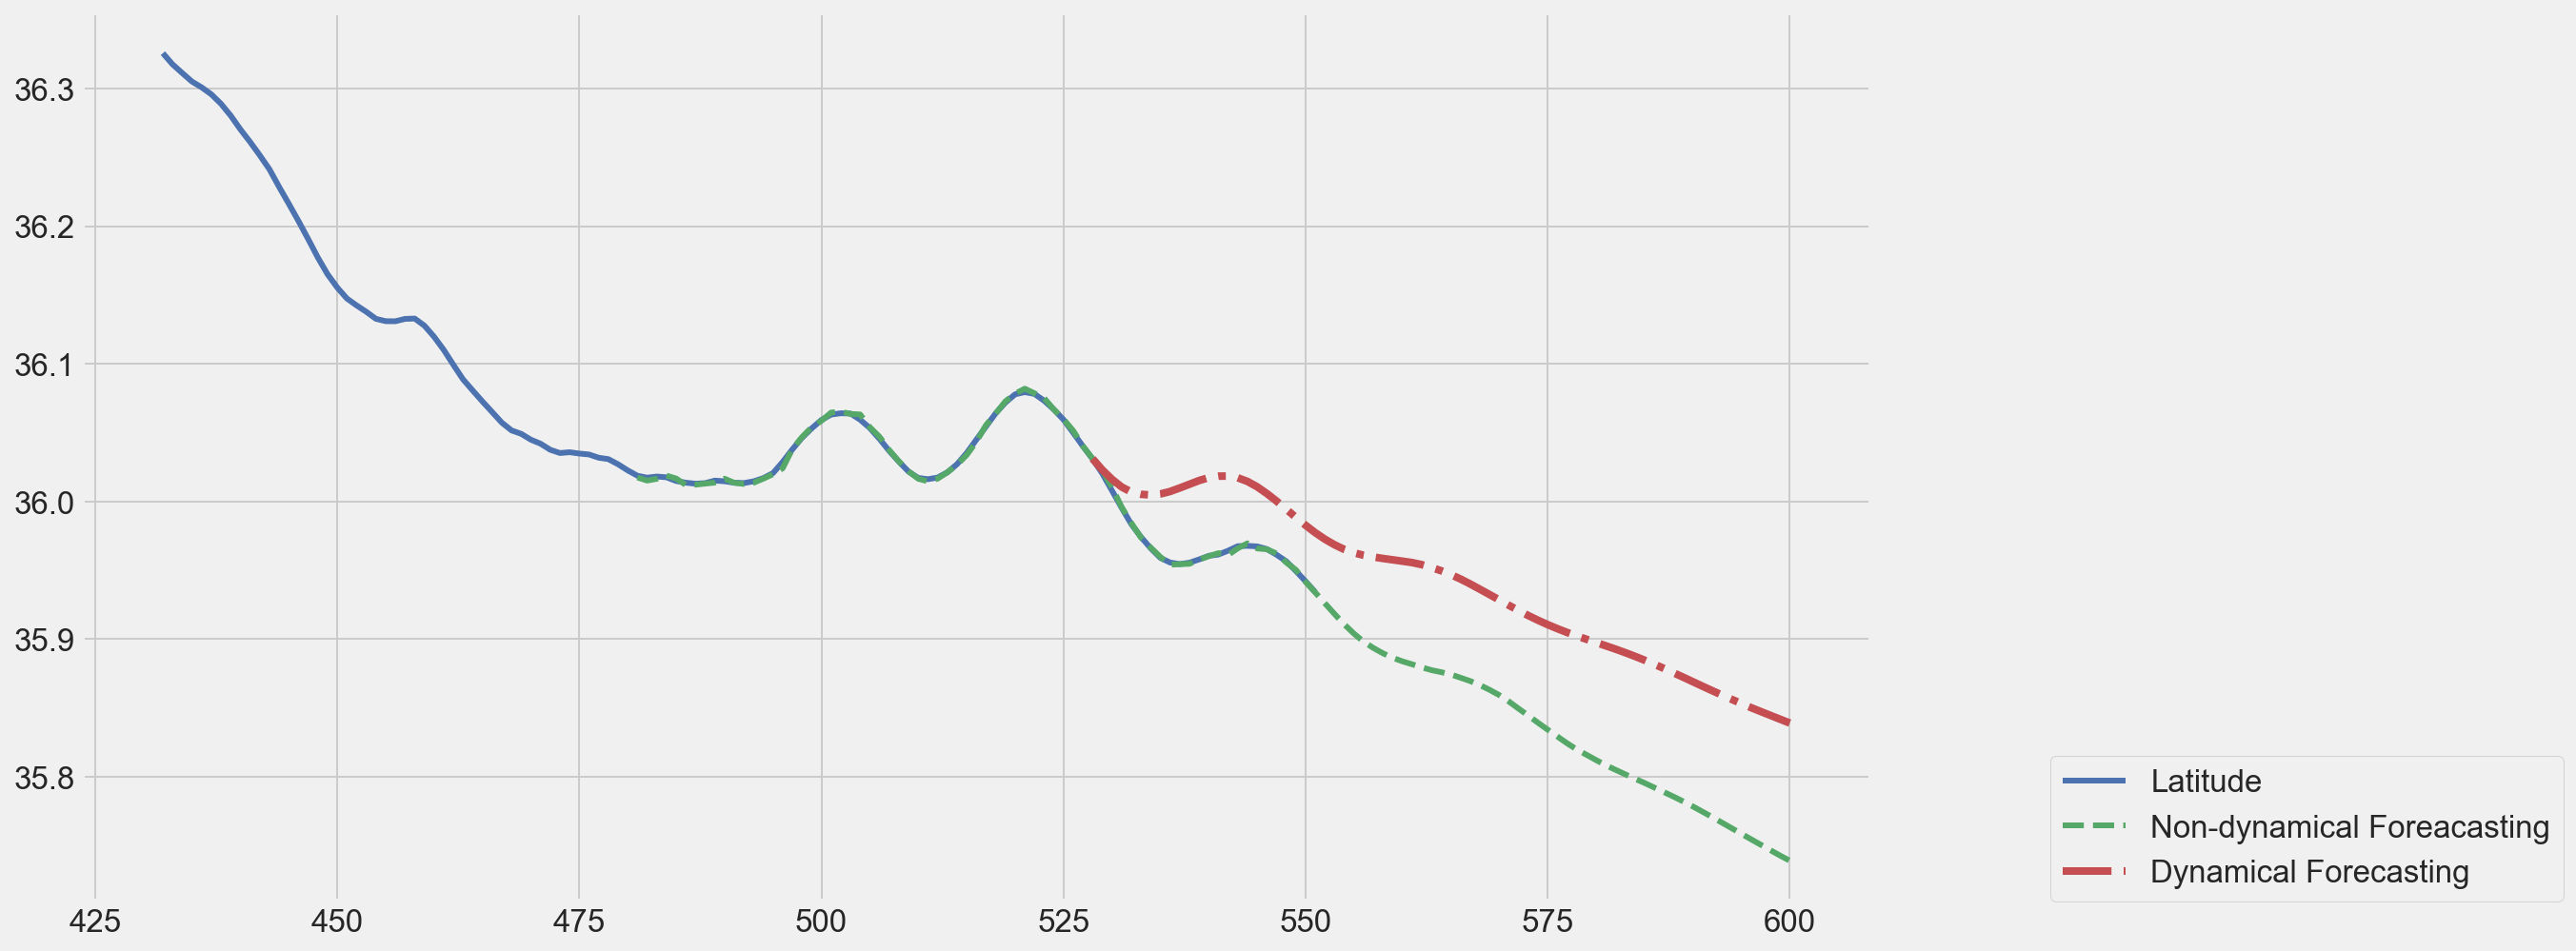

In [9]:
make_predict(data=buoy_data, buoy_id=35, feature='Latitude', order=(41, 2, 1), start_p=24, end_p=48)

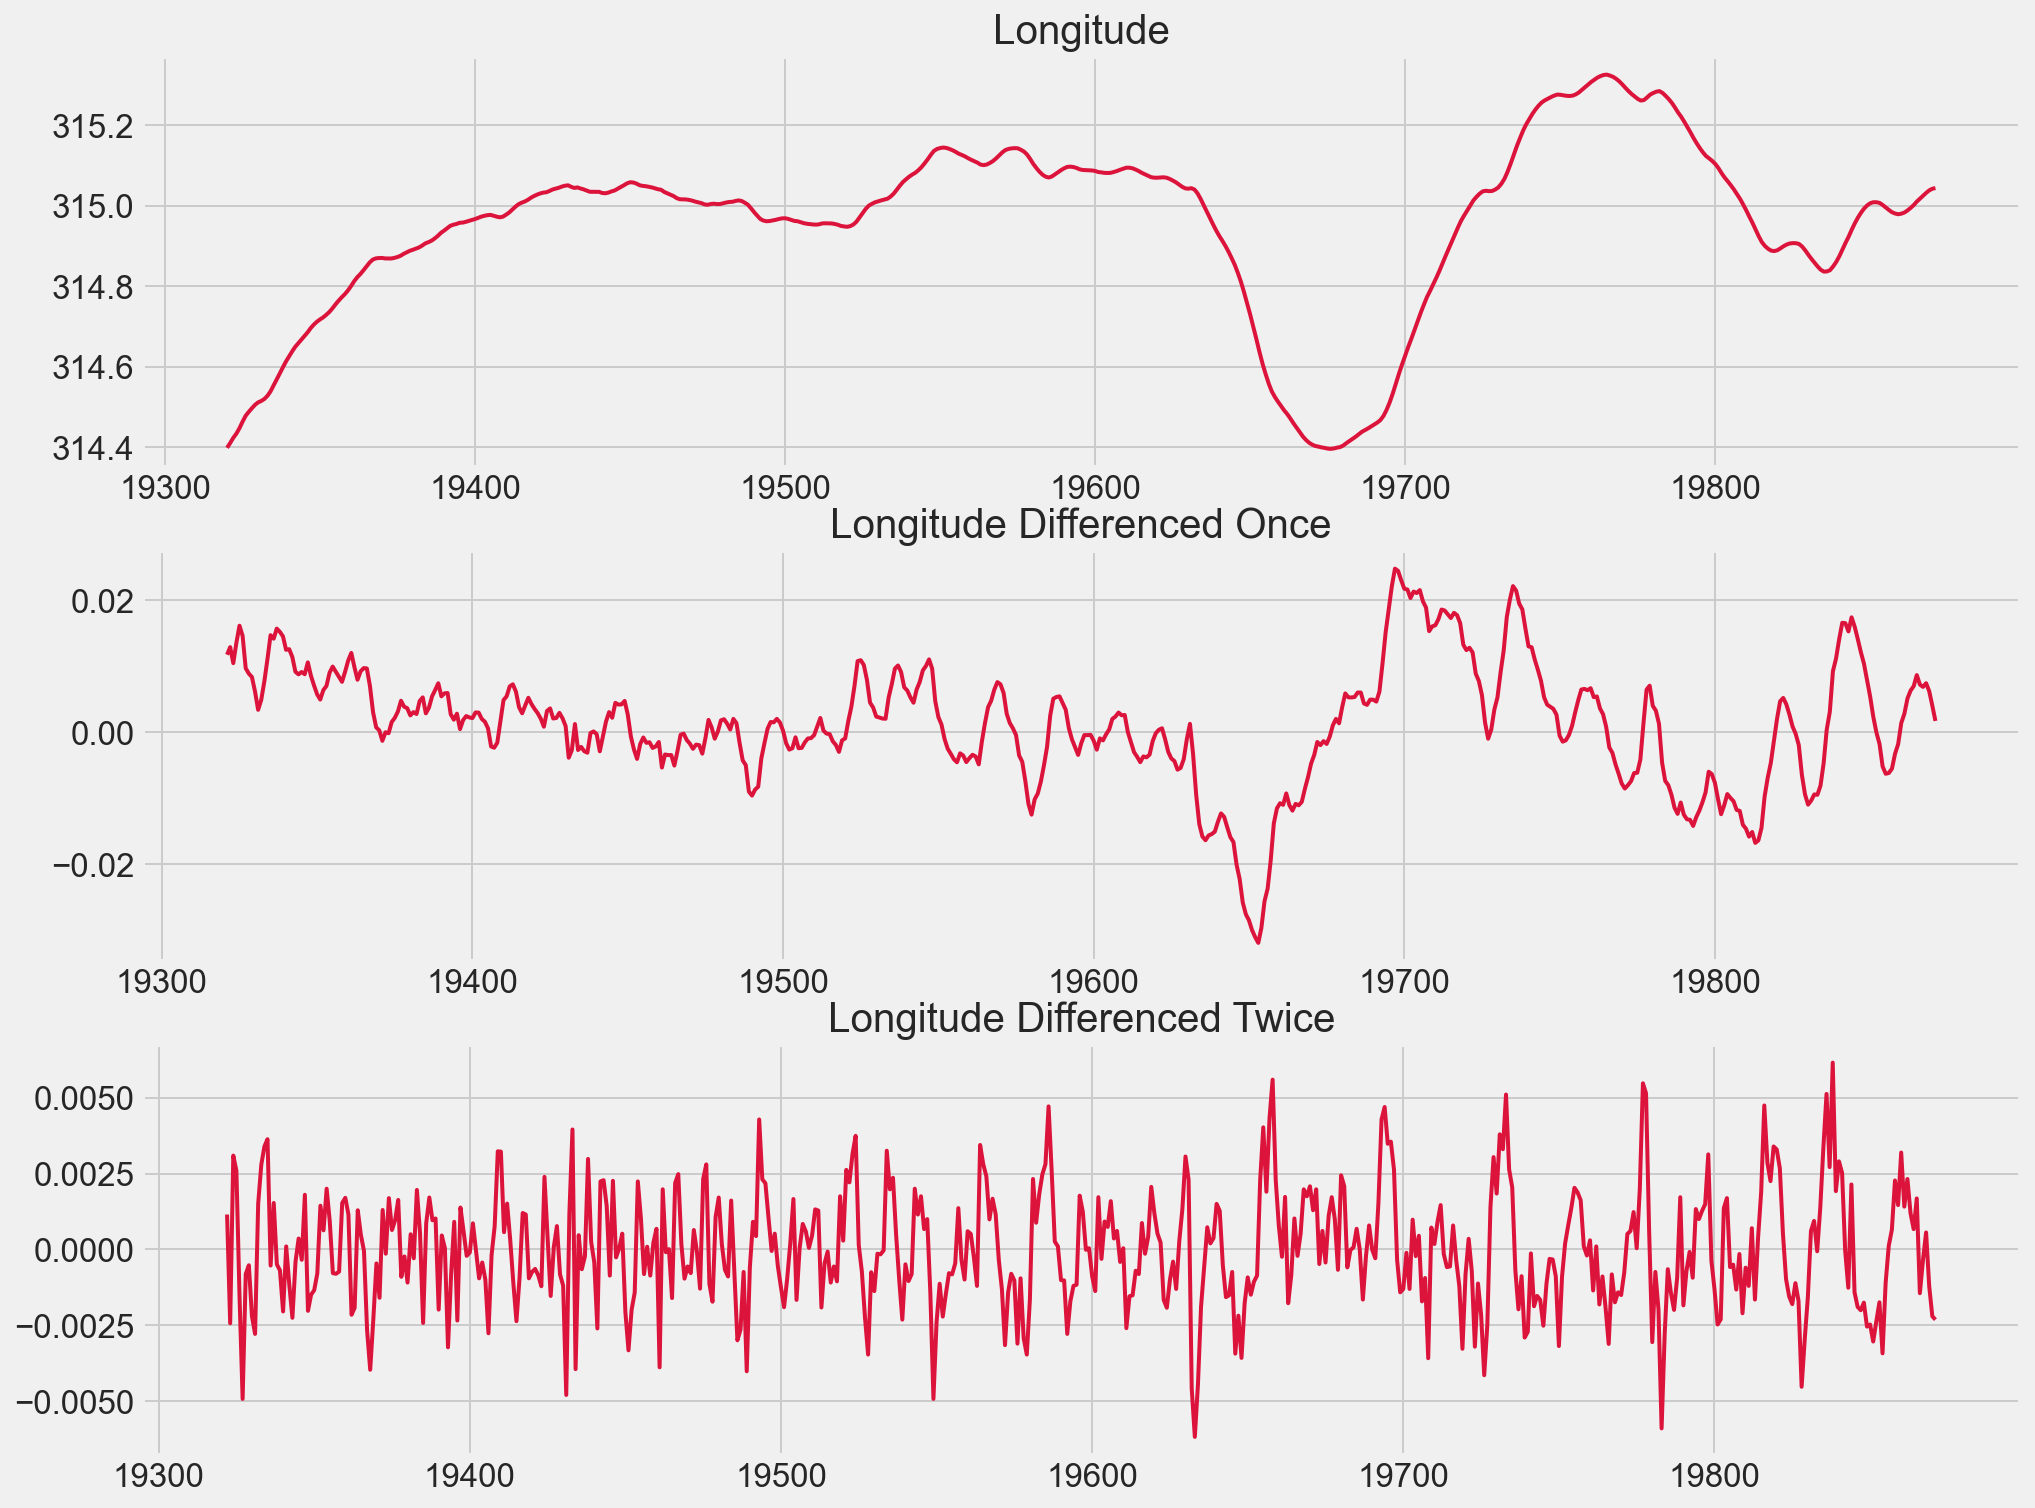

In [10]:
plot_diff(buoy_data, 35, 'Longitude')

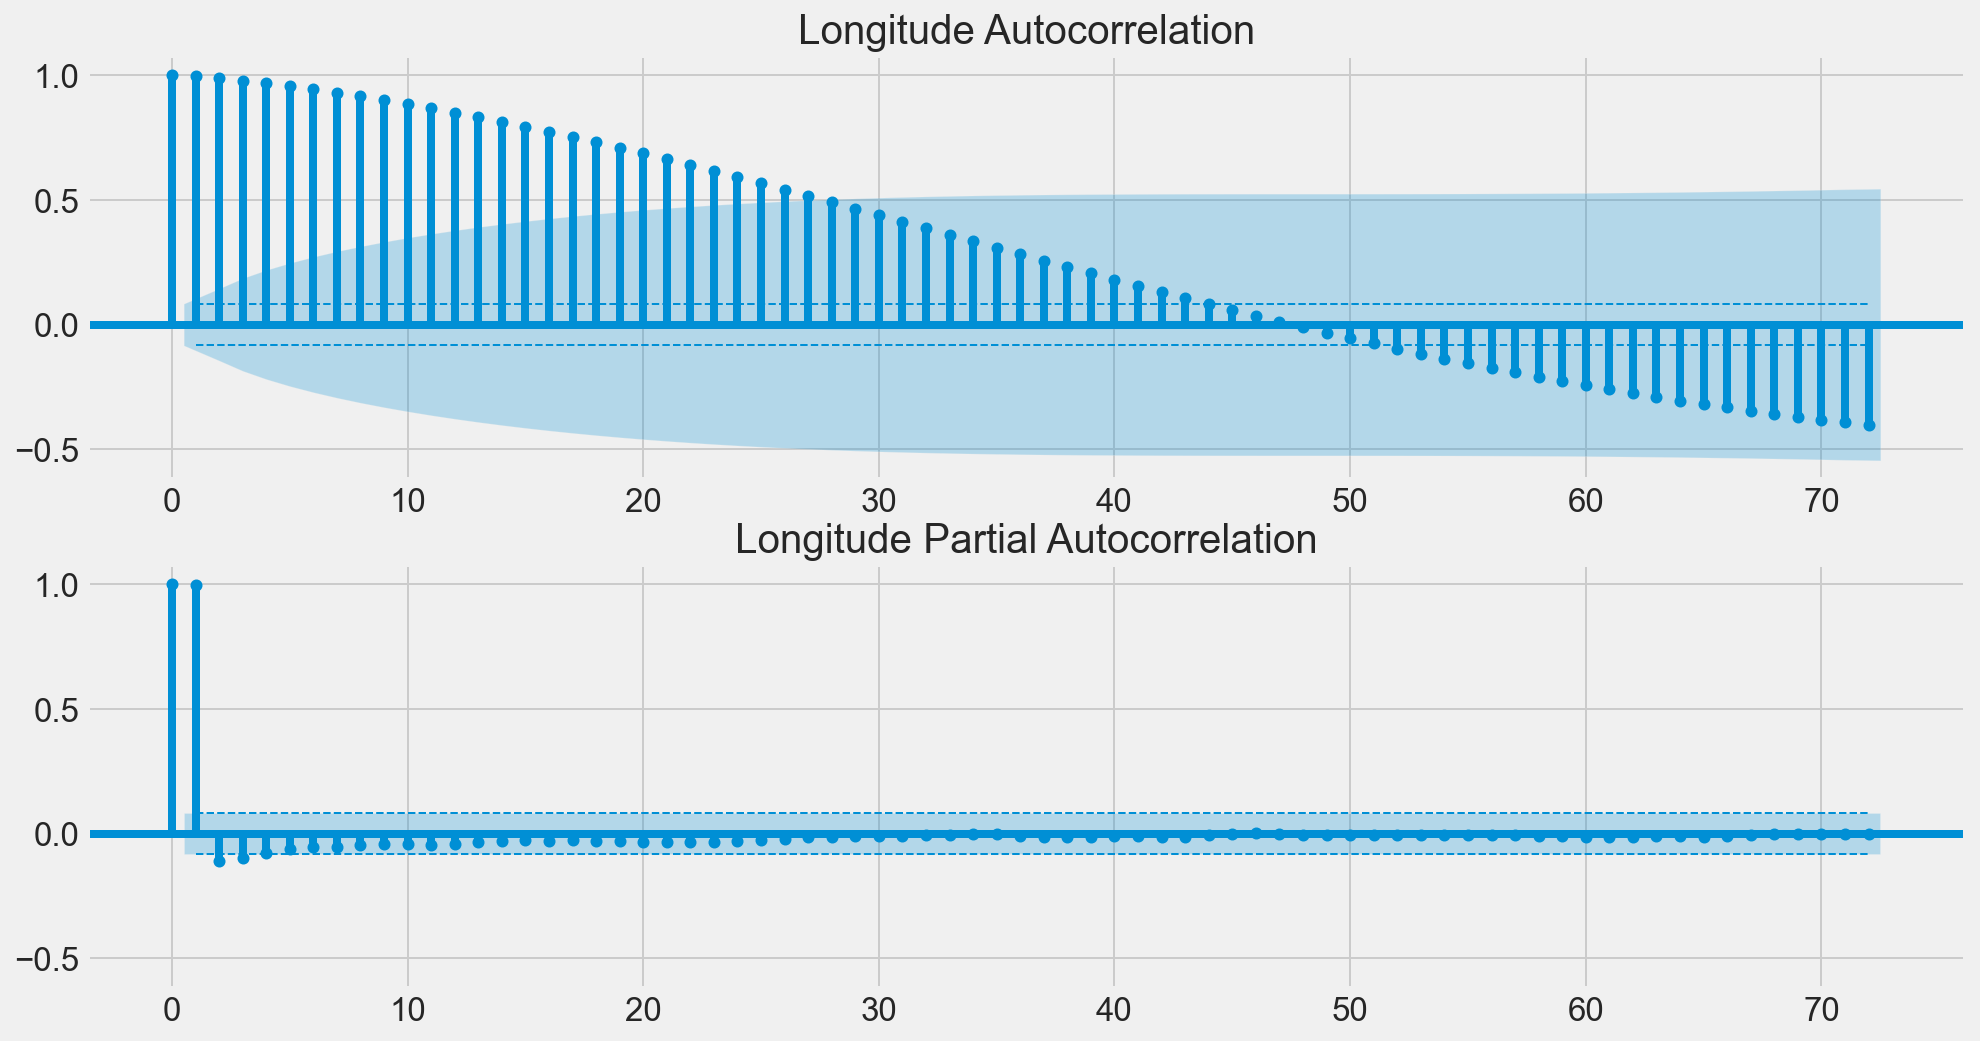

In [11]:
plot_autocorrs(buoy_data, 35, 'Longitude', 72)

                               SARIMAX Results                                
Dep. Variable:              Longitude   No. Observations:                  552
Model:              SARIMAX(27, 2, 4)   Log Likelihood                2784.882
Date:                Wed, 24 Nov 2021   AIC                          -5503.765
Time:                        10:36:42   BIC                          -5361.537
Sample:                             0   HQIC                         -5448.185
                                - 552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.458e-05   8.96e-05     -0.163      0.871      -0.000       0.000
ar.L1          0.2586      0.254      1.019      0.308      -0.239       0.756
ar.L2          0.0550      0.483      0.114      0.9

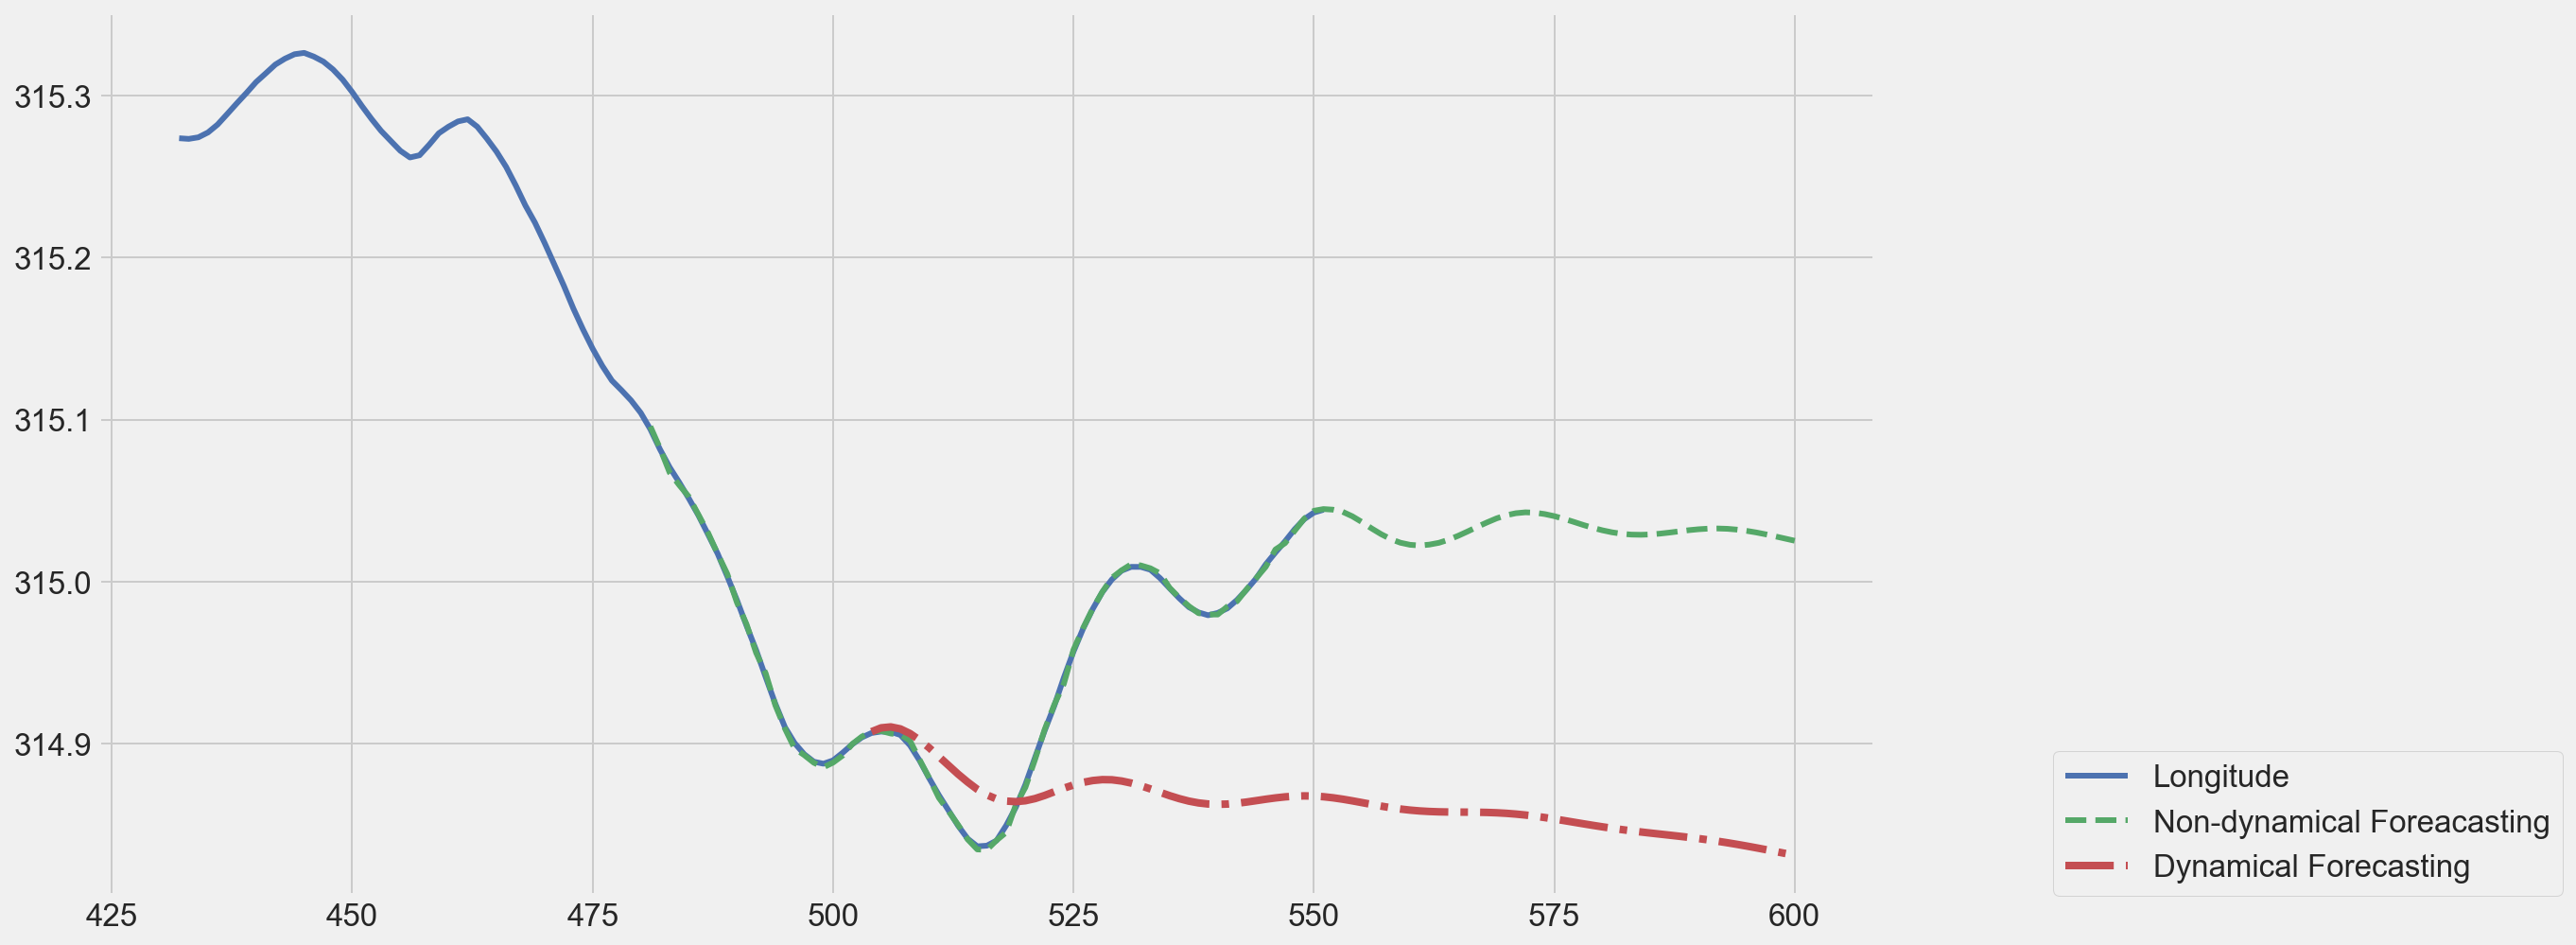

In [12]:
make_predict(data=buoy_data, buoy_id=35, feature='Longitude', order=(27, 2, 4), start_p=48, end_p=48)